In [38]:
import torch 
import torch as th
import numpy as np
from dptb.plugins.init_nnsk import InitSKModel
from dptb.nnops.NN2HRK import NN2HRK
from dptb.nnops.apihost import NNSKHost
from ase.io import read,write
from dptb.structure.structure import BaseStruct
import matplotlib.pyplot as plt
from dptb.postprocess.bandstructure.band import bandcalc
import pickle as pickle
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
checkfile = './ckpt/2-2-2_best_nnsk_b5.000_c5.000_w0.100.pth'
f = torch.load(checkfile)
# define nnskapi for tb model.
nnskapi = NNSKHost(checkpoint=checkfile)
nnskapi.register_plugin(InitSKModel())
nnskapi.build()
# define nnHrk for Hamiltonian model.
nnHrk = NN2HRK(apihost=nnskapi, mode='nnsk')

# initial rotate H or S func.


In [17]:
# read structure
atoms = read('./data/silicon.vasp', format='vasp')
# transfer structure to the nnHrk model.
nnHrk.update_struct(structure=atoms)
# get the Hamiltonian matrix.
allbonds, hamil_blocks, overlap_blocks = nnHrk.get_HR()
# Since we use orthogonal basis, the overlap_blocks is None.
# allbonds is a list of bonds, each bond is a tensor of (an_i,i,an_j,j,vec).
print(allbonds[0])
# an_i and an_j are the atomic numbers of atom i and j. Since this is a silicon mode. atom i and j are both silicon. an_i and an_j are both 14.
# vec is the vector from atom i to atom j. which is the lattice vector R.
# hamil_blocks is a list of Hamiltonian blocks, each block is a tensor of shape (norb_i, norb_j). 
# norb_i and norb_j are the number of orbitals of atom i and j. Since this is a silicon mode. atom i and j are both silicon, and we use s,p,d orbitals for Si. norb_i and norb_j are both 9.
# the order of the list of allbonds and hamil_blocks is the same. that is, allbonds[i] is the bond corresponding to hamil_blocks[i].
print(hamil_blocks[0].shape)

tensor([14,  0, 14,  0,  0,  0,  0], dtype=torch.int32)
torch.Size([9, 9])


In [26]:
# get the band structure.
# define the kpoints.
# suppose we want to get the band structure along [0,0,0] -> [0.5,0,0.5]
kpath_list = [[x,0,x] for x in np.linspace(0,0.5,30)]
eigenvalues, estimated_E_fermi = nnHrk.get_eigenvalues(kpoints=kpath_list)


(-15.0, 15.0)

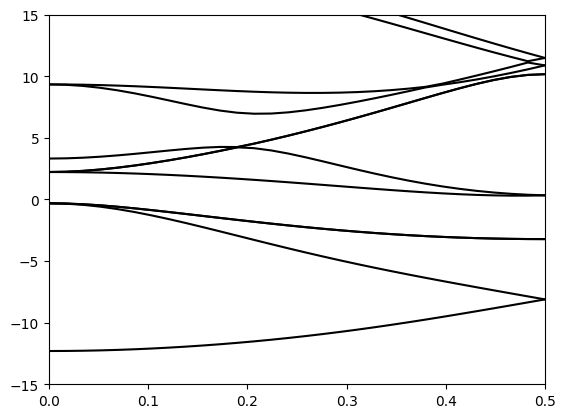

In [36]:
plt.plot(np.linspace(0,0.5,30), eigenvalues-estimated_E_fermi,'k-')
plt.xlim([0,0.5])
plt.ylim([-15,15])

In [37]:
nnHrk

In [44]:
# get band for obtained Hamiltonian blocks.

def hs_block_R2k(all_bonds, hamil_blocks, kpoints, numOrbs, time_symm=True):
    """ transfer HR to HK.

    Args:
        all_bonds (list): list of bonds, each bond is a tensor of (an_i,i,an_j,j,vec).
        hamil_blocks (list): list of Hamiltonian blocks, each block is a tensor of shape (norb_i, norb_j).
        kpoints (list): list of kpoints.
        numOrbs (list): list of number of orbitals for each atom.
        time_symm (bool, optional): whether the Hamiltonian is time reversal symmetric. Defaults to True.

    Returns:
        Hk (tensor): Hamiltonian matrix in k space.
    
    """
    totalOrbs = np.sum(numOrbs)
    hijAll = hamil_blocks
    Hk = th.zeros([len(kpoints), totalOrbs, totalOrbs], dtype = th.complex64)
    for ik in range(len(kpoints)):
        k = kpoints[ik]
        hk = th.zeros([totalOrbs,totalOrbs],dtype = th.complex64)
        for ib in range(len(all_bonds)):
            Rlatt = all_bonds[ib,4:7].int()
            i = all_bonds[ib,1].int()
            j = all_bonds[ib,3].int()
            ist = int(np.sum(numOrbs[0:i]))
            ied = int(np.sum(numOrbs[0:i+1]))
            jst = int(np.sum(numOrbs[0:j]))
            jed = int(np.sum(numOrbs[0:j+1]))
            if ib < len(numOrbs): 
                """
                len(numOrbs)= numatoms. the first numatoms are onsite energies.
                if turn on timeSymm when generating the bond list <i,j>. only i>= or <= j are included. 
                if turn off timeSymm when generating the bond list <i,j>. all the i j are included.
                for case 1, H = H+H^\dagger to get the full matrix, the the onsite one is doubled.
                for case 2. no need to do H = H+H^dagger. since the matrix is already full.
                """
                if time_symm:
                    hk[ist:ied,jst:jed] += 0.5 * hijAll[ib] * np.exp(-1j * 2 * np.pi* np.dot(k,Rlatt))
                else:
                    hk[ist:ied,jst:jed] += hijAll[ib] * np.exp(-1j * 2 * np.pi* np.dot(k,Rlatt)) 
            else:
                hk[ist:ied,jst:jed] += hijAll[ib] * np.exp(-1j * 2 * np.pi* np.dot(k,Rlatt)) 
        if time_symm:
            hk = hk + hk.T.conj()
        Hk[ik] = hk
    Hk.contiguous()
        
    return Hk

In [46]:
# numOrbs = [9,9] means we use s,p,d orbitals for Si. and there are two Si atoms in the structure file.
HK = hs_block_R2k(all_bonds=allbonds, hamil_blocks=hamil_blocks, kpoints=kpath_list, numOrbs=[9,9])

In [49]:
eigs = torch.linalg.eigvalsh(HK)

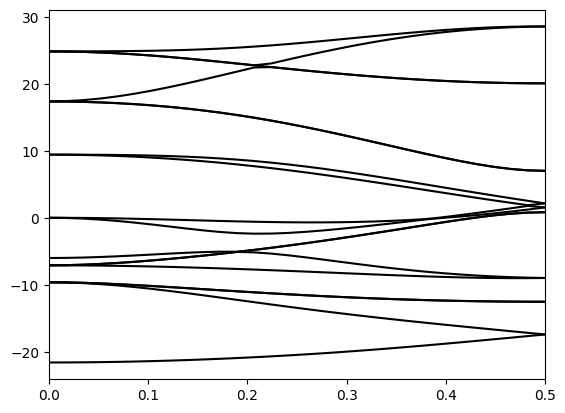

In [67]:
Hartree2eV = 27.211386245988
plt.plot(np.linspace(0,0.5,30), eigs.detach().numpy()*Hartree2eV,'k-')
plt.xlim([0,0.5])
#plt.ylim([-15,15])
plt.show()

In [ ]:
# Hartree to eV
